In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from peft import LoraConfig, get_peft_model, TaskType, PeftModel
from torch.amp import autocast, GradScaler
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from data_loader import load_dataset, format_input_with_context, LABEL2ID, ID2LABEL

# Training

In [2]:
# hyperparameters (through wandb sweep)

MODEL_NAME = "vinai/bertweet-large"
BATCH_SIZE = 8
LEARNING_RATE = 0.00004
NUM_EPOCHS = 20
WARMUP_RATIO = 0.15
WEIGHT_DECAY = 0.05
EARLY_STOPPING_PATIENCE = 3 # stop if no improvement after this many epoichs

MAX_LENGTH = 256
N_LABELS = len(LABEL2ID) # 4 SDQC

LORA_TARGET_MODULES = ["query", "value"]
LORA_ALPHA = 48
LORA_R = 20
LORA_DROPOUT = 0.1

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
RAND_SEED = 42 # for reproducing results
torch.manual_seed(RAND_SEED)
np.random.seed(RAND_SEED)

CHECKPOINT_DIR = "./results/classifier/"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

RETRAIN_MODEL = False # whether to replace existing model in checkpoint_dir and train new one

In [3]:
# dataset
class InputDataset(Dataset):
    """
    preload with format_input_with_context() to create classifier inputs    
    """ 
    def __init__(self, df, tokenizer, max_length=MAX_LENGTH, use_context=True, use_features=True):
        self.df = df.reset_index(drop=True)
        self.full_df = df
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_context = use_context
        self.use_features = use_features
        
        self.inputs = []
        for idx in range(len(self.df)):
            row = self.df.iloc[idx]
            formatted = format_input_with_context(
                row, self.full_df, 
                use_features=use_features, 
                use_context=use_context,
                max_tokens=max_length,
                tokenizer=tokenizer
            )
            self.inputs.append(formatted)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = self.inputs[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(row['label'], dtype=torch.long)
        }
    

In [4]:
# model

def compute_class_weights(train_df):
    """
    use inverse frequency weighting to give minority classes more importance
        weight for class i = total_samples / (num_classes * count_i)
    """
    label_counts = train_df['label'].value_counts().sort_index()
    n, k = len(train_df), len(label_counts)
    weights = [n / (k * label_counts.get(i, 1)) for i in range(k)]
    return torch.tensor(weights, dtype=torch.float32)

def create_model():    
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=N_LABELS,
        problem_type="single_label_classification"
    )
    
    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=LORA_R,
        lora_alpha=LORA_ALPHA,
        lora_dropout=LORA_DROPOUT,
        target_modules=LORA_TARGET_MODULES,
        bias="none",
    )
    
    model = get_peft_model(model, lora_config)
    model.print_trainable_parameters()
    return model.to(DEVICE)



In [5]:
# train helpers

def train_epoch(model, dataloader, optimizer, scheduler, criterion, scaler=None):
    """train for one epoch with optional mixed precision"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    use_amp = scaler is not None
    
    progress_bar = tqdm(dataloader, desc="Training", leave=False) # leave = false removes bar when done
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)
        
        optimizer.zero_grad()
        
        # use autocast for mixed precision in forward pass
        with autocast(device_type=DEVICE.type, enabled=use_amp):
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            logits = outputs.logits
            loss = criterion(logits, labels)
        
        # use scaler for mixed precision in backward pass
        if use_amp:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        scheduler.step()
        
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        progress_bar.set_postfix({'loss': loss.item()})
    
    avg_loss = total_loss / len(dataloader)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    
    return avg_loss, macro_f1


def evaluate(model, dataloader, loss_fn):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            logits = outputs.logits
            loss = loss_fn(logits, labels)
            
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    
    return avg_loss, macro_f1, all_preds, all_labels


In [6]:
# pipeline

def train(train_df, dev_df, verbose=False):
    # get class weights for loss function
    class_weights = compute_class_weights(train_df).to(DEVICE)
    if verbose: print(f"Class weights: {class_weights.cpu().numpy()}")
    
    # tokenizer and load datasets
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)
    
    train_dataset = InputDataset(train_df, tokenizer, MAX_LENGTH)
    dev_dataset = InputDataset(dev_df, tokenizer, MAX_LENGTH)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # init model
    model = create_model()
    
    # init optimizer, scheduler, loss fn
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY
    )
    
    total_steps = len(train_loader) * NUM_EPOCHS
    warmup_steps = int(total_steps * WARMUP_RATIO)
    
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )
    
    # use weighted cross-entropy loss
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    
    # mixed precision on cuda
    use_amp = DEVICE.type == "cuda"
    scaler = GradScaler("cuda") if use_amp else None
    
    # train loop
    best_f1 = 0
    epochs_without_improvement = 0
    
    logs = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []}
    
    for epoch in tqdm(range(NUM_EPOCHS), desc="Epochs"):        
        # train
        train_loss, train_f1 = train_epoch(
            model, train_loader, optimizer, scheduler, loss_fn, scaler
        )
        
        # eval
        val_loss, val_f1, _, _ = evaluate(
            model, dev_loader, loss_fn
        )
        
        logs['train_loss'].append(train_loss)
        logs['train_f1'].append(train_f1)
        logs['val_loss'].append(val_loss)
        logs['val_f1'].append(val_f1)
        
        # save best model
        if val_f1 > best_f1:
            best_f1 = val_f1
            epochs_without_improvement = 0
            
            # save chekckpoint
            checkpoint_path = os.path.join(CHECKPOINT_DIR, "best_model")
            model.save_pretrained(checkpoint_path)
            tokenizer.save_pretrained(checkpoint_path)
        else:
            epochs_without_improvement += 1
            if verbose: print(f"No improvement for {epochs_without_improvement} epochs")
            
            if epochs_without_improvement >= EARLY_STOPPING_PATIENCE:
                if verbose: print(f"\nEarly stopping triggered after {epoch + 1} epochs")
                break
    
    return model, tokenizer, logs


In [7]:
# load data
train_df, dev_df, test_df = load_dataset()


Loading cached data from saved_data/datasets.pkl...


In [8]:
# train / load model
checkpoint_path = os.path.join(CHECKPOINT_DIR, "best_model") if CHECKPOINT_DIR else None # path to model
logs_csv_path = os.path.join(CHECKPOINT_DIR, "training_logs.csv") if CHECKPOINT_DIR else None # path to training logs

if not os.path.exists(checkpoint_path) or RETRAIN_MODEL:
    model, tokenizer, logs = train(train_df, dev_df)
    pd.DataFrame(logs).to_csv(logs_csv_path, index=False) # save training logs
else:
    print(f"Loading {checkpoint_path}")
    tokenizer = AutoTokenizer.from_pretrained(checkpoint_path, use_fast=False)
    base_model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=N_LABELS,
        problem_type="single_label_classification"
    )
    model = PeftModel.from_pretrained(base_model, checkpoint_path)
    model = model.to(DEVICE)

Loading ./results/classifier/best_model


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Analysis

Training diagnostics plot saved to ./results/classifier/train_diag.png


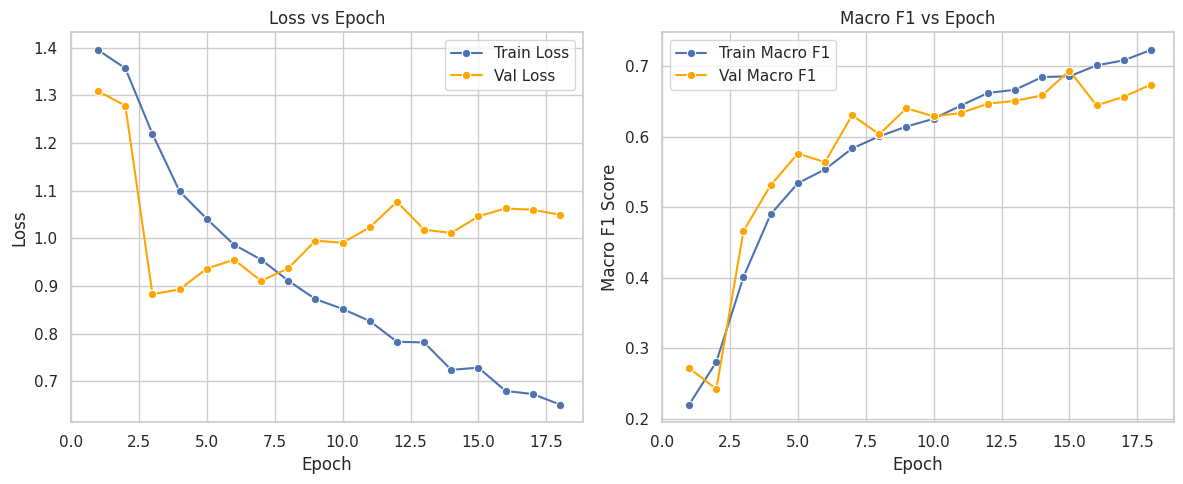

In [9]:
# training diagnostics from csv (if exists)
if logs_csv_path and os.path.exists(logs_csv_path):
    logs_df = pd.read_csv(logs_csv_path)
    epochs = range(1, len(logs_df) + 1)
    
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 5))
    
    # loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x=list(epochs), y=logs_df['train_loss'], marker='o', label='Train Loss')
    sns.lineplot(x=list(epochs), y=logs_df['val_loss'], marker='o', color='orange', label='Val Loss')
    plt.title('Loss vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xlim(0)
    
    # f1
    plt.subplot(1, 2, 2)
    sns.lineplot(x=list(epochs), y=logs_df['train_f1'], marker='o', label='Train Macro F1')
    sns.lineplot(x=list(epochs), y=logs_df['val_f1'], marker='o', color='orange', label='Val Macro F1')
    plt.title('Macro F1 vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Macro F1 Score')
    plt.xlim(0)
    
    plt.tight_layout()
    if CHECKPOINT_DIR:
        save_path = os.path.join(CHECKPOINT_DIR, "train_diag.png")
        plt.savefig(save_path)
        print(f"Training diagnostics plot saved to {save_path}")
    plt.show()


In [10]:
# evaluate on test set
test_dataset = InputDataset(test_df, tokenizer, MAX_LENGTH)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class_weights = compute_class_weights(train_df).to(DEVICE)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

test_loss, test_f1, test_preds, test_labels = evaluate(
    model, test_loader, loss_fn
)

# classification report
print(classification_report(
    test_labels, test_preds,
    target_names=list(LABEL2ID.keys())
))

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]

              precision    recall  f1-score   support

     support       0.36      0.39      0.38        94
        deny       0.33      0.63      0.43        71
       query       0.59      0.85      0.70       106
     comment       0.89      0.75      0.81       778

    accuracy                           0.72      1049
   macro avg       0.54      0.66      0.58      1049
weighted avg       0.77      0.72      0.74      1049



Confusion matrix saved to ./results/classifier/test_confusion_matrix.png


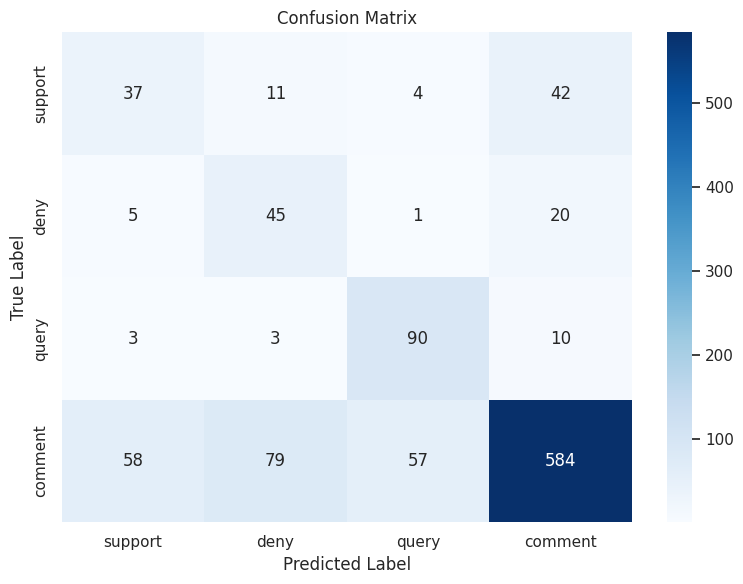

In [11]:
# confusion matrix
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(LABEL2ID.keys()), 
            yticklabels=list(LABEL2ID.keys()))
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

if CHECKPOINT_DIR:
    save_path = os.path.join(CHECKPOINT_DIR, "test_confusion_matrix.png")
    plt.savefig(save_path)
    print(f"Confusion matrix saved to {save_path}")
plt.show()

In [12]:
# get classifier row for full comparison in nb_3
labels = ['support', 'deny', 'query', 'comment']
per_class_f1 = f1_score(test_labels, test_preds, average=None, labels=[LABEL2ID[l] for l in labels])

classifier_row = {
    'strategy': 'classifier',
    'repeat': 1,
    'macro_f1': test_f1,
    'support_f1': per_class_f1[0],
    'deny_f1': per_class_f1[1],
    'query_f1': per_class_f1[2],
    'comment_f1': per_class_f1[3],
}

exp4_csv_path = os.path.join(CHECKPOINT_DIR, "classifier_full_comparison.csv")
pd.DataFrame([classifier_row]).to_csv(exp4_csv_path, index=False)
print(f"Saved to {exp4_csv_path}")

# copy & paste these into full_comparioson.csv in results/prompting

Exp4-compatible classifier results saved to ./results/classifier/classifier_exp4_results.csv
